### QGIS CSV merges per PHU
**Authors:** Sofia and KT

In [38]:
import os
import numpy as np
import pandas as pd
import glob
import missingno as msno

---
### Import and Clean Data


In [22]:
#os.chdir('../data/QGIS_csv_files/')

In [201]:
# read data
prox = pd.read_csv('../PMD-en/PMD-on.csv')
qgis = pd.read_csv('../QGIS_csv_files/Joined_DB_to_PHU.csv')
#dbpop = pd.read_csv('../QGIS_csv_files/DBPOP.csv')
covid = pd.read_csv('../covid_comorbidities.csv')
census = pd.read_excel('../PMD-en/phu_census.xlsx', sheet_name = "ON")

In [202]:
# only keep necessary columns
qgis = qgis[['fid', 'DBUID', 'PRUID', 'PRNAME', 'CSDUID', 'CSDNAME', 'CSDTYPE', 'CMAUID', 'CMAPUID', 
     'CMANAME', 'CMATYPE', 'HR_UID', 'ENG_LABEL', 'FRE_LABEL']]

In [203]:
# remove rows that don't have prox data ~ 141 rows removed
prox2 = prox[prox['prox_idx_emp'] != 'F']

# convert .. to np.nan
list_prox = ['prox_idx_emp', 'prox_idx_pharma', 'prox_idx_childcare',
            'prox_idx_health', 'prox_idx_grocery', 'prox_idx_educpri',
            'prox_idx_educsec', 'prox_idx_lib', 'prox_idx_parks',
            'prox_idx_transit']

for each in list_prox:
    prox2[each] = prox2[each].replace({"..":np.nan})

# convert to float
prox2[list_prox] = prox2[list_prox].astype(float)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [204]:
prox2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132711 entries, 0 to 133213
Data columns (total 41 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   DBUID               132711 non-null  int64  
 1   DBPOP               132602 non-null  object 
 2   DAUID               132711 non-null  int64  
 3   DAPOP               132602 non-null  object 
 4   CSDUID              132711 non-null  int64  
 5   CSDNAME             132711 non-null  object 
 6   CSDTYPE             132711 non-null  object 
 7   CSDPOP              132602 non-null  object 
 8   CMAUID              97533 non-null   float64
 9   CMAPUID             97533 non-null   float64
 10  CMANAME             97533 non-null   object 
 11  CMATYPE             97533 non-null   object 
 12  CMAPOP              97533 non-null   object 
 13  PRUID               132711 non-null  int64  
 14  PRNAME              132711 non-null  object 
 15  PRPOP               132711 non-nul

---
### Merge PHU covid data with PHU census data

In [205]:
covidmerge = pd.merge(covid, census, how = 'inner', on = 'DGUID')

In [206]:
# convert census type
covidmerge['Census'] = covidmerge['Census'].str.replace(',', '').astype(int)

---
### Rename QGIS data HRs to PHUs given by Ontario Case Data

> ***Old Comment:*** (Reference `comorbidities-merges.ipynb` for justifications.)

`Location` column in `covidmerge` and `ENG_LABEL` in `qgis` represent PHU.

`Reporting_PHU` has different names.

In [207]:
# QGIS
qgis.rename(columns = {'ENG_LABEL' : 'Location'}, inplace = True)

# qgis.Reporting_PHU.replace({'York Regional Health Unit' : 'York Region Public Health Services',
#               'Waterloo Health Unit' : 'Region of Waterloo, Public Health',
#             'Halton Regional Health Unit' : 'Halton Region Health Department',
#               'Lambton Health Unit' : 'Lambton Public Health',
#              'Durham Regional Health Unit' : 'Durham Region Health Department',  
#              'City of Ottawa Health Unit' : 'Ottawa Public Health', 
#              'Peel Regional Health Unit': 'Peel Public Health',
#               'Wellington-Dufferin-Guelph Health Unit': 'Wellington-Dufferin-Guelph Public Health',
#             'Kingston, Frontenac and Lennox and Addington Health Unit' : 'Kingston, Frontenac and Lennox & Addington Public Health',
#              'The Eastern Ontario Health Unit':'Eastern Ontario Health Unit',
#               'City of Hamilton Health Unit':'Hamilton Public Health Services',
#               'Niagara Regional Area Health Unit':'Niagara Region Public Health Department',
#               'Sudbury and District Health Unit':'Sudbury & District Health Unit',
#              'The District of Algoma Health Unit':'Algoma Public Health Unit',
#              'Peterborough County - City Health Unit':'Peterborough Public Health',
#              'City of Toronto Health Unit' : 'Toronto Public Health',
#               'Perth District Health Unit' : 'Huron Perth District Health Unit',
#             'Huron County Health Unit' : 'Huron Perth District Health Unit',
#             'Elgin-St. Thomas Health Unit' : 'Southwestern Public Health',
#             'Oxford County Health Unit' : 'Southwestern Public Health'}, inplace = True)

In [208]:
# merge
merge = pd.merge(qgis, prox2, how = 'inner', on = 'DBUID')

In [210]:
# convert DBPOP to int
merge['DBPOP'] = merge['DBPOP'].str.replace(",", "")
merge['DBPOP'].replace({np.nan:0}, inplace = True)
merge['DBPOP'] = merge['DBPOP'].map(lambda x: int(x))

In [221]:
merge[merge['DBPOP'].isna()]

,fid,DBUID,PRUID_x,PRNAME_x,CSDUID_x,CSDNAME_x,CSDTYPE_x,CMAUID_x,CMAPUID_x,CMANAME_x,...,prox_idx_educsec,in_db_lib,prox_idx_lib,in_db_parks,prox_idx_parks,in_db_transit,prox_idx_transit,transit_na,amenity_dense,suppressed


### Missing data by DB

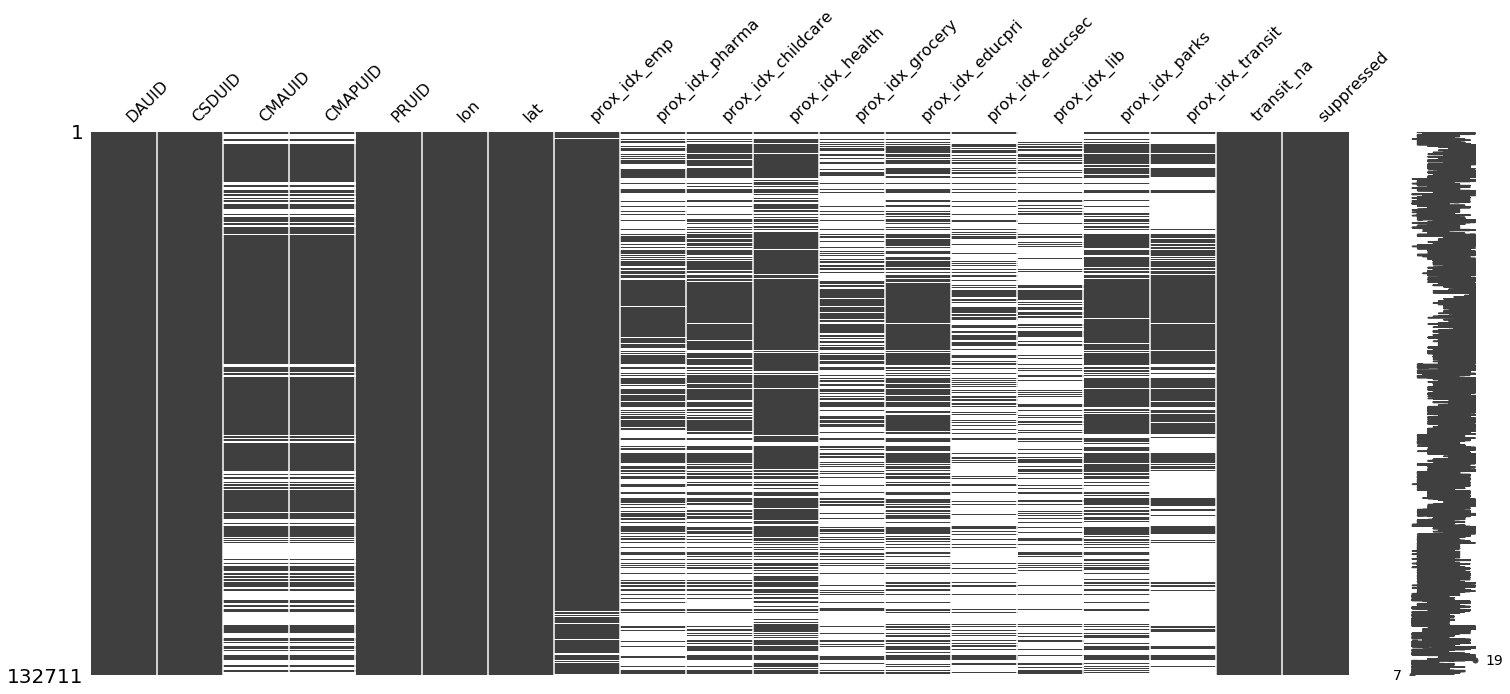

In [112]:
msno.matrix(prox2.groupby('DBUID').median())

In [226]:
# calc median of proximity per PHU
phu_med = merge.groupby('Location').median()

In [228]:
# convert DBPOP from median to sum
phu_med['DBPOP'] = merge.groupby('Location').sum()['DBPOP']

#### missing data by PHU

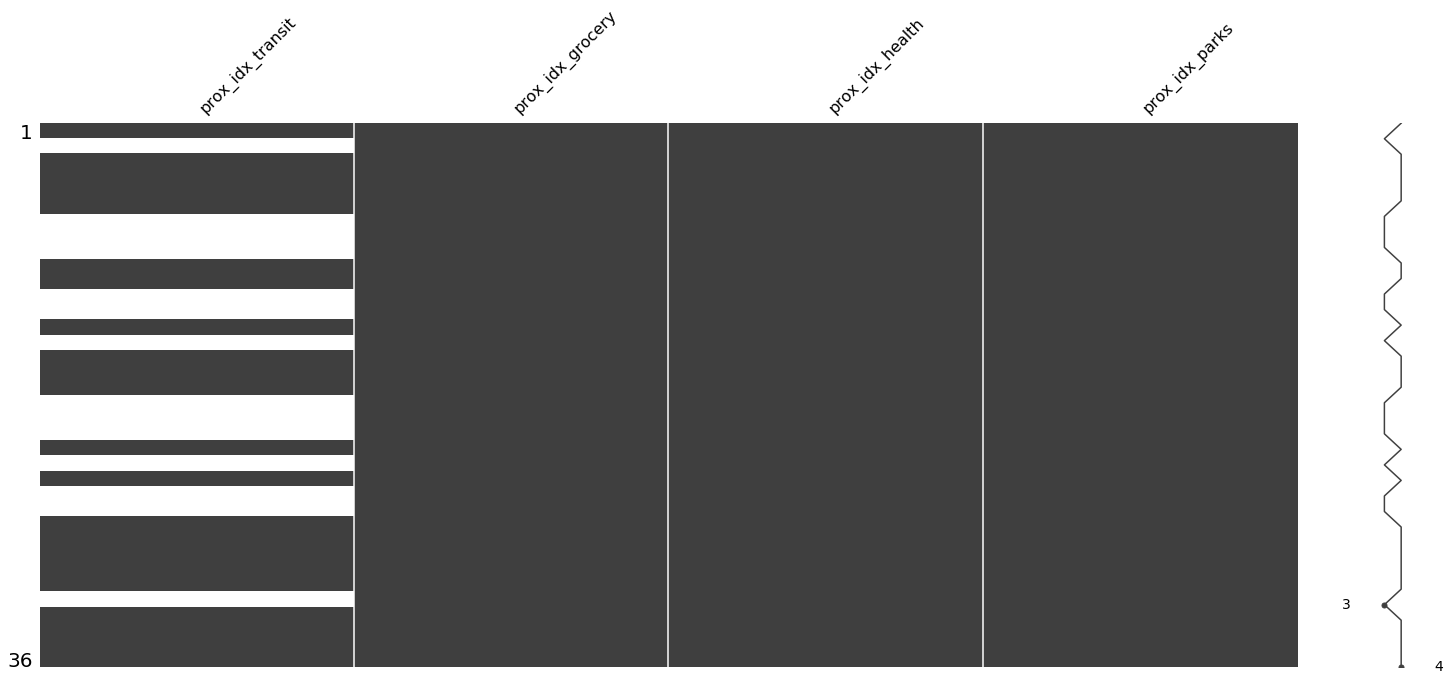

In [115]:
# missing data by PHU
msno.matrix(phu_med[['prox_idx_transit', 'prox_idx_grocery', 'prox_idx_health', 'prox_idx_parks',]])

In [229]:
# merge with covid
pd.merge(covidmerge, phu_med, 
         how = 'outer', on = 'Location').drop(['PRUID_x', 
                                                        'CSDUID_x', 'CMAUID_x'], axis = 1).to_csv('../PMD-en/PHU_FINAL_prop.csv')

In [236]:
# numeric columns to keep 
numeric_keep = ['DGUID', 'DBPOP', 'Reporting_PHU', 'copd', 'asthma', 'hbp', 'smokers', 'FEMALE', 'MALE', 'TRANSGENDER', 
                'UNKNOWN', 'OTHER', 'CONTACT', 'NEITHER', 'TRAVEL-RELATED', 'NOT-RESOLVED', 'RESOLVED', 'FATAL',
               'TOTAL', 'Census', 'Location', 'fid', 'DBUID', 'PRUID_x', 'CSDUID_x', 'CMAUID_x', 'CMAPUID_x', 'HR_UID', 'DAUID',
               'lon', 'lat', 'prox_idx_emp', 'prox_idx_pharma', 'prox_idx_childcare', 'prox_idx_health', 
                'prox_idx_grocery', 'prox_idx_educpri', 'prox_idx_educsec', 'prox_idx_lib', 'prox_idx_parks', 
                'prox_idx_transit', 'transit_na', 'suppressed']

# proportion columns to keep
prop_keep = ['DGUID', 'DBPOP', 'Reporting_PHU', 'copd-percent', 'asthma-percent', 'hbp-percent', 'smokers-percent', 'FEMALEprop', 
             'MALEprop', 'TRANSGENDERprop', 
            'UNKNOWNprop', 'OTHERprop', 'CONTACTprop', 'NEITHERprop', 'TRAVEL-RELATEDprop', 'NOT-RESOLVEDprop',
             'RESOLVEDprop', 'FATALprop', 'TOTALprop', 'Census', 'Location', 'fid', 'DBUID', 'PRUID_x', 'CSDUID_x', 'CMAUID_x', 
             'CMAPUID_x', 'HR_UID', 'DAUID', 'lon', 'lat', 'prox_idx_emp', 'prox_idx_pharma', 'prox_idx_childcare', 
             'prox_idx_health', 'prox_idx_grocery', 'prox_idx_educpri', 'prox_idx_educsec', 'prox_idx_lib', 'prox_idx_parks', 
                'prox_idx_transit', 'transit_na', 'suppressed']

# merge covid with proximity/QGIS data
fullmerge = pd.merge(covidmerge, phu_med, how = 'outer', on = 'Location')




**Calculate proportions for covid numbers:**

In [237]:
convert = ['FEMALE', 'MALE', 'TRANSGENDER', 'UNKNOWN', 'OTHER', 'CONTACT', 'NEITHER', 'TRAVEL-RELATED', 'NOT-RESOLVED',
          'RESOLVED', 'FATAL', 'TOTAL']

for c in convert:
    fullmerge[c+'prop'] = fullmerge[c]/fullmerge['DBPOP']
    

In [238]:
fullmerge[prop_keep].to_csv('../PMD-en/PHU_FINAL_prop.csv')
fullmerge[numeric_keep].to_csv('../PMD-en/PHU_FINAL_num.csv')